In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import adabmDCA
from adabmDCA.utils import get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler
from adabmDCA.functional import one_hot

import sys
sys.path.append('..')
import selex_dca

File names for data

In [3]:
experiment_id = "Dop8V930"
round_ids = ["ARN", "R01", "R02N"]

In [4]:
device = get_device("")
dtype = get_dtype("float32")

Running on CPU


Extract sequences and compute 1st and 2nd moment statistics

In [6]:
sequences = [selex_dca.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [7]:
ts = range(len(sequences))

In [8]:
pseudo_count = 0

In [9]:
freq_single_tuple, freq_pair_tuple, total_reads_tuple = zip(
    *[selex_dca.frequences_from_sequences(seq, pseudo_count=pseudo_count, dtype=dtype) for seq in sequences])

In [10]:
fi = torch.stack(freq_single_tuple)  # n_rounds, L, q
fij = torch.stack(freq_pair_tuple)      # n_rounds, L, q, L, q
total_reads = torch.tensor(total_reads_tuple, dtype=dtype)

n_rounds, L, q = fi.size()

Pick a sampling strategy for MCMC

In [11]:
sampler_alg = "gibbs"
sampler = torch.jit.script(get_sampler(sampler_alg))

In [12]:
nchains = 10000

params = selex_dca.init_parameters(fi=fi) # initialize with frequences at last round
chains = selex_dca.init_chains(num_rounds=n_rounds, num_chains=nchains, L=L, q=q, device=device, fi=fi)
history = selex_dca.init_history()

Train

In [13]:
nsweeps = 10
lr = 0.01

ch, par, history = selex_dca.train(
    sampler=sampler,
    chains=chains,
    fi=fi,
    fij=fij,
    total_reads=total_reads,
    params=params,
    nsweeps=nsweeps,
    lr=lr,
    max_epochs=6000,
    target_pearson=0.95,
    history=history,
    progress_bar=True
    )

 0.00%[                                                                     ] Epoch: 0/6000 [00:00]

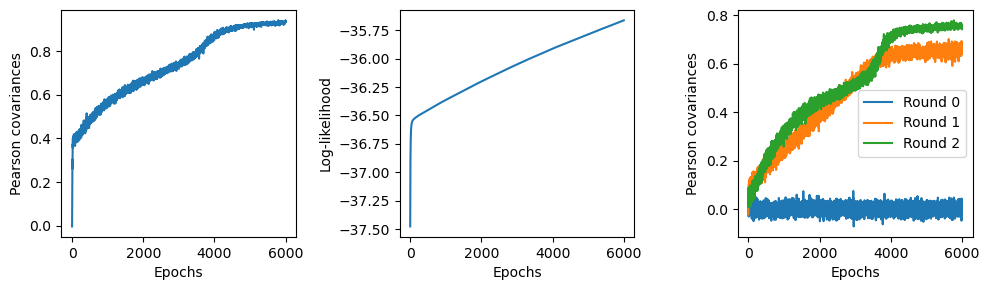

In [14]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))
ax1.plot(history["pearson"])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Pearson covariances")
ax2.plot(history["log-likelihood"])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Log-likelihood")
ax3.plot(history["pearson_rounds"], label=[f"Round {r}" for r in range(len(round_ids))])
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Pearson covariances")
ax3.legend()
f.tight_layout()

## Explore Nst

In [15]:
sequences_all = torch.cat(sequences, dim=0)
sequences_all_unique = torch.unique(sequences_all, dim=0)
sequences_all_unique_oh = one_hot(sequences_all_unique)

In [16]:
logNst_unique = [-adabmDCA.statmech.compute_energy(
    sequences_all_unique_oh, 
    selex_dca.get_params_at_round(params, t))
           for t in ts]

In [17]:
M_logNst = torch.stack(logNst_unique).numpy()
corrs = np.corrcoef(M_logNst)

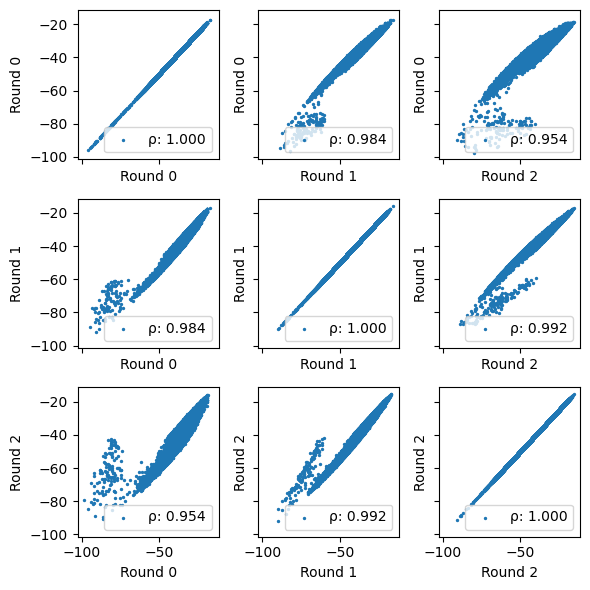

In [20]:
N = 10**5

fig, axes = plt.subplots(3,3, figsize=(6,6), sharex=True, sharey=True)

for t in ts:
    for u in ts:
        ax = axes[u,t]
        x = logNst_unique[t]
        y = logNst_unique[u]
        idx = random.sample(range(len(x)),min(N, len(x)))
        ax.scatter(x[idx], y[idx], label=f"ρ: {corrs[t,u]:.3f}", s=2)
        ax.set_xlabel("Round " + str(t))
        ax.set_ylabel("Round " + str(u))
        ax.legend()
plt.tight_layout()

plt.savefig(f"img/{experiment_id}_corr_Ns0.png")

### Compare with empirical abundances

In [16]:
logNst, sequences_unique, inverse_indices, counts = selex_dca.compute_logNst(sequences, params)

In [17]:
logNst_thresh = -100

In [18]:
ts = range(len(round_ids))
X, Y = zip(*[
    vectors_for_scatterplot_single_t_unique(logNst[t], counts[t], logNst_thresh, inverse_indices[t])
    for t in ts])

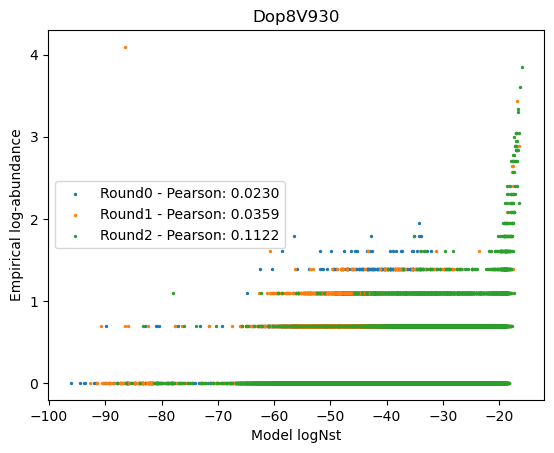

In [19]:
import random
N = 10**5

fig, ax = plt.subplots()

for t in ts:
    x = X[t]; y = Y[t]
    pearson = torch.corrcoef(torch.stack((x, y)))[0,1]
    idx = random.sample(range(len(x)),min(N, len(x)))
    ax.scatter(x[idx], y[idx], label=f"Round{t} - Pearson: {pearson:.{4}f}", s=2)
    ax.set_xlabel("Model logNst")
    ax.set_ylabel("Empirical log-abundance")
    ax.set_title(f"{experiment_id}")
ax.legend();

### Wildtypes

In [21]:
idx_wt_full, wt_full = selex_dca.guess_wildtype_from_sequence_counts(sequences_unique[0], counts[0])
wt_site = selex_dca.guess_wildtype_from_site_counts(fi[0])

NameError: name 'sequences_unique' is not defined

In [21]:
selex_dca.hamming(wt_full, wt_site)

0

In [22]:
selex_dca.hamming(params["bias_Ns0"].argmax(dim=1), wt_site)

0

In [42]:
logNst_wt, _, _, _ = selex_dca.compute_logNst([wt_site[None,:] for _ in round_ids], params)

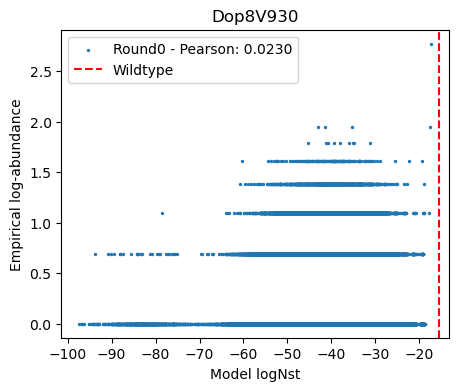

In [43]:
N = 5*10**5

fig, ax = plt.subplots(figsize=(5,4))

t = 0
x = X[t]; y = Y[t]
pearson = torch.corrcoef(torch.stack((x, y)))[0,1]
idx = random.sample(range(len(x)),min(N, len(x)))
ax.scatter(x[idx], y[idx], label=f"Round{t} - Pearson: {pearson:.{4}f}", s=2)
ax.set_xlabel("Model logNst")
ax.set_ylabel("Empirical log-abundance")
ax.set_title(f"{experiment_id}")
ax.axvline(logNst_wt[t], label="Wildtype", c="r", ls="--")
ax.legend();

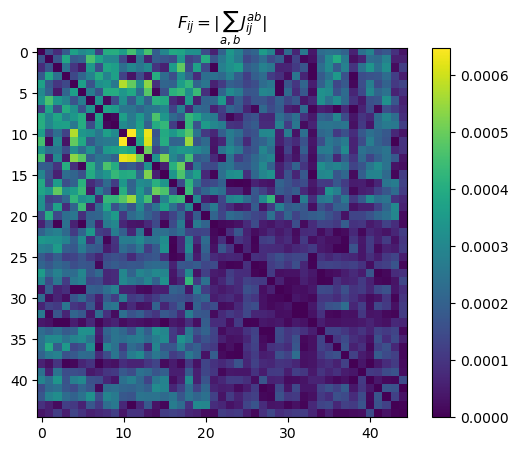

In [22]:
J = params["couplings_ps"]
F = J.sum(dim=(1,3)).abs()
plt.imshow(F)
plt.colorbar()
plt.title(r"$F_{ij}=|\sum_{a,b}J_{ij}^{ab}|$");

## Save stuff

In [24]:
import pickle

filename = experiment_id + ".pkl"
filepath = "saved/" + filename

data = [experiment_id, round_ids, params]

with open(filepath, 'wb') as f:
    pickle.dump(data, f)